We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Fetus EDA.

In [2]:
### DATA PREPARATION
fetus = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\fetal_health.csv')

df = pd.DataFrame(fetus)
df.rename(columns = {'baseline value': 'baseline_value'}, inplace = True)

df['fetal_health'] = df['fetal_health'].astype('category')

df.drop(['histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_width', 'histogram_min'], axis = 1, inplace = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of healthy, suspect and unhealthy fetuses.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df.drop(['fetal_health'], axis = 1)
y = df['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 123)

We now go on to make a simple Decision Tree model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of normal fetuses was way more than fetuses which were either suspects or were unhealthy; fetuses with major health issues were only about 8%. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the three levels of y, the weight of each level being inversely proportional to its frequency.

So, we build the model with class weights as balanced, fit it to the training data and plot the confusion matrix.

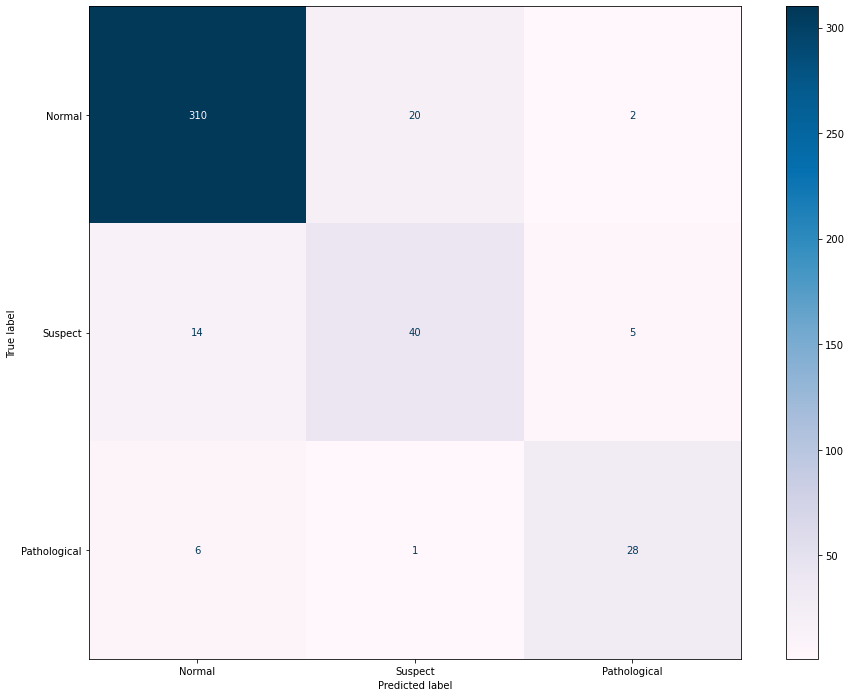

In [4]:
### CREATING A BASELINE MODEL
clf_dt = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced')
clf_dt.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (16, 12))
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['Normal', 'Suspect', 'Pathological'], ax = ax, cmap = plt.cm.PuBu)

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [5]:
df['fetal_health'].value_counts(normalize = True)

1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: fetal_health, dtype: float64

Here, we see that around 78% of the fetuses in our dataset are normal as opposed to just about 14% which are suspects and about 8% which have health issues. This means that even if our model predicts every fetus as normal, the model will still be 78% accurate at the very least. So, in this case, accuracy is a deceptive metric.

What we should rather be concerned with is the number of fetuses that actually had major issues but were not identified by the model as having any i.e. the False Negatives for Pathological fetuses. The lower this FN value is, lower is the risk of overlooking a possible health issue and thus better is the model because the main objective of the model here should be to identify unhealthy fetuses. To reduce the FN value for Pathological fetuses, we need to ensure that the recall and F1 scores are high since recall and FN are inversely proportional and F1 is the harmonic mean of recall and precision.

So, we shall calculate the accuracy, recall and F1 values for the predictions made by the model. The parameter _'average'_ in the metrics is used for multiclass classifications like the present scenario. We shall set its value as _'weighted'_, which will calculate the metrics for each level and return their average weighted by the number of true samples in each level.

In [6]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['Normal', 'Suspect', 'Pathological']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt, average = 'weighted'))
print('F1 score: %f' % f1_score(y_test, y_pred_dt, average = 'weighted'))

              precision    recall  f1-score   support

      Normal       0.94      0.93      0.94       332
     Suspect       0.66      0.68      0.67        59
Pathological       0.80      0.80      0.80        35

    accuracy                           0.89       426
   macro avg       0.80      0.80      0.80       426
weighted avg       0.89      0.89      0.89       426

Accuracy: 0.887324
Recall score: 0.887324
F1 score: 0.887957


If we look at the confusion matrix, we see that out of the 35 fetuses that actually had major issues, 28 were correctly predicted as having one by our model while 1 was said to be a suspect and the remaining 6 were deemed normal. Also, of the 59 suspected fetuses, 40 were correctly identified while 14 were deemed as being normal. This gives us a recall score of about 88.7%, an F1 score of about 88.8% and an accuracy of about 88.7%.

Next, we shall plot the tree model that we have just made.

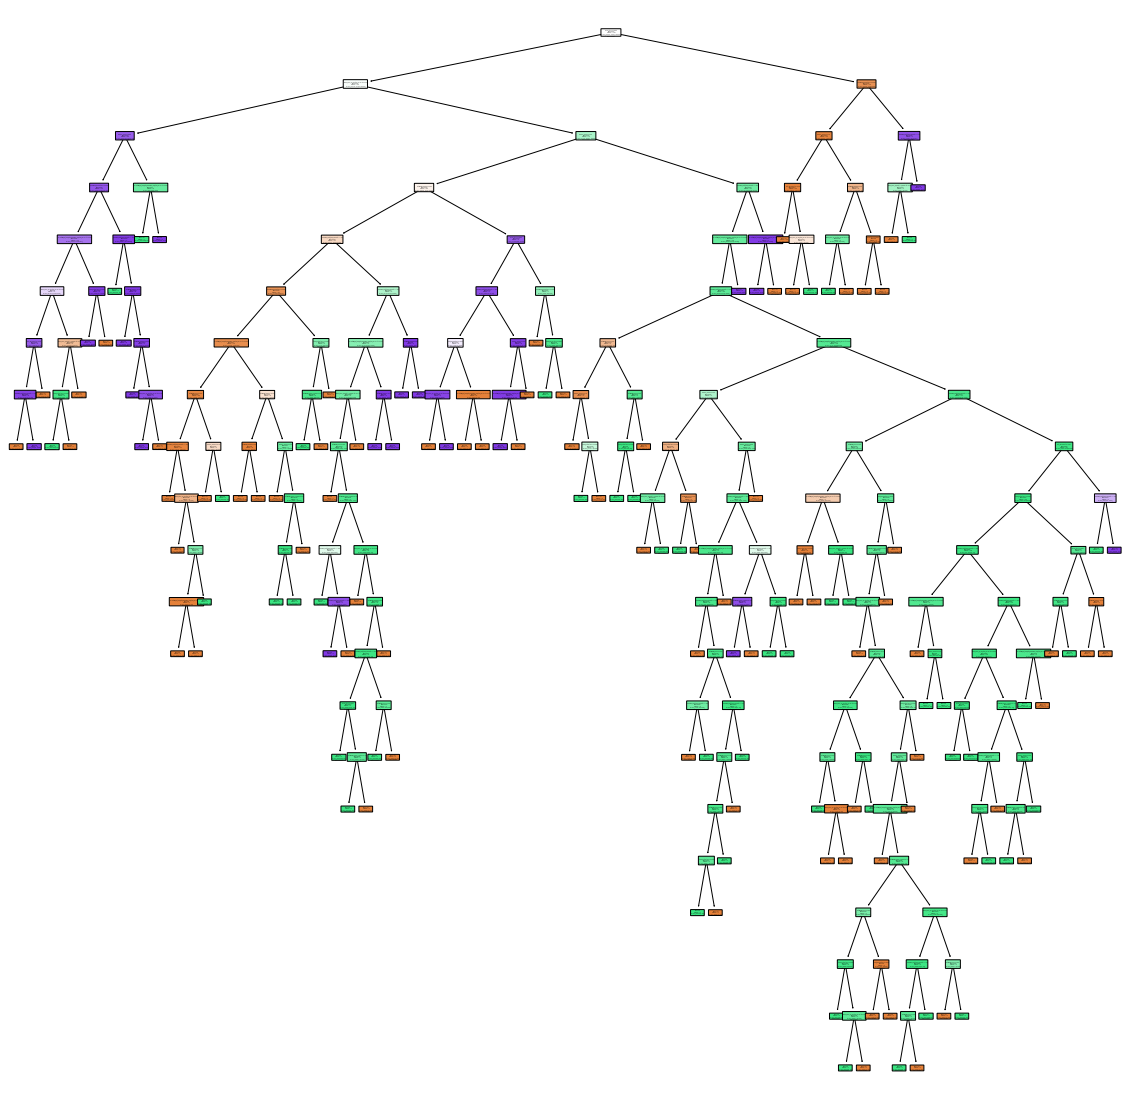

In [7]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (20, 20))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['Normal', 'Suspect', 'Pathological'], feature_names = X.columns);

We see that our baseline model is a huge tree which might have been overfit to the training data and thus can be improved to get better results. To improve this, we can try to prune the tree to make it small so that it will fit well with new data. For this, we can make use of Cost Complexity Pruning.

Suppose we have numerous trees of varying sizes- from a single leaf to the tree in the baseline model, then Cost Complexity Pruning assigns a Tree Score to each tree, where the score of a tree is calculated as the sum of it's SSRs and ccp_alpha times the total number of it's terminal nodes. The tree with the lowest Tree Score is considered to be the pruned tree.

So, in order to prune the baseline tree model, we shall first need an ideal ccp_alpha value. For this, let us extract a range of possible values for ccp_alpha and then use them to create numerous models with which we can calculate the F1 score for both the training and testing sets. We can plot these F1 scores on a graph against the ccp_alpha values.

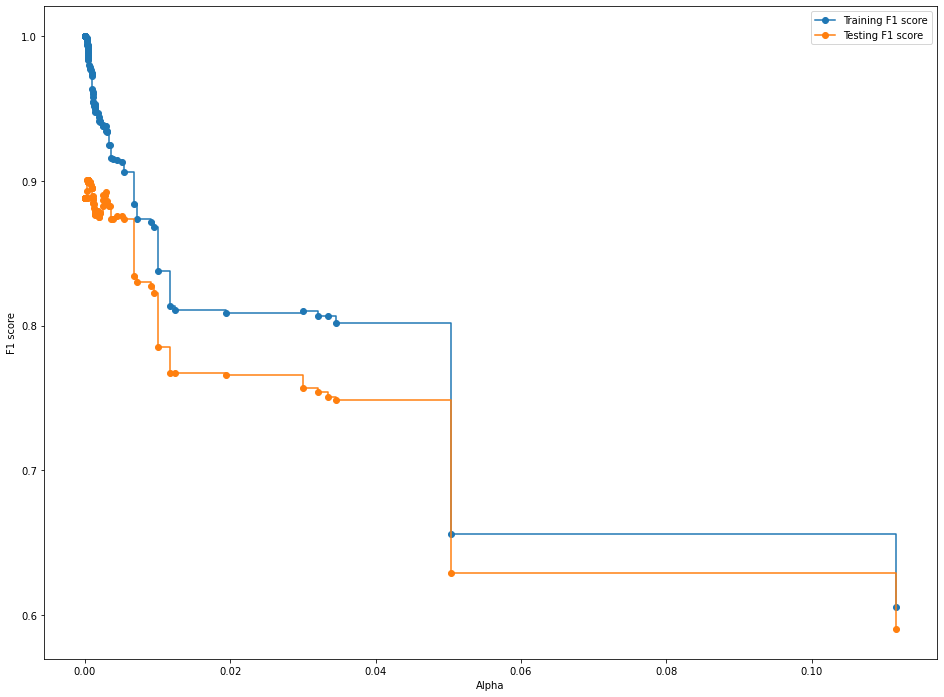

In [8]:
### PLOTTING F1 SCORES FOR TRAINING AND TESTING AGAINST CCP_ALPHA VALUES
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]
training_f1 = []
testing_f1 = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced', ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    training_f1.append(f1_score(y_train, y_train_pred, average = 'weighted'))
    testing_f1.append(f1_score(y_test, y_test_pred, average = 'weighted'))
fig, ax = plt.subplots(figsize = (16, 12))
ax.set_xlabel('Alpha')
ax.set_ylabel('F1 score')
ax.plot(ccp_alphas, training_f1, label = 'Training F1 score', marker = 'o', drawstyle = 'steps-post')
ax.plot(ccp_alphas, testing_f1, label = 'Testing F1 score', marker = 'o', drawstyle = 'steps-post')
ax.legend()
plt.show()

We can see the F1 score for the testing data being around 90% in the interval 0.00 < ccp_alpha < 0.02. Now, to find the ideal value, we shall use 5-fold cross validation on the training data with f1_weighted as the scoring parameter. We store the average results from the cross validation on a dataframe and plot it on a graph against the ccp_alpha values.

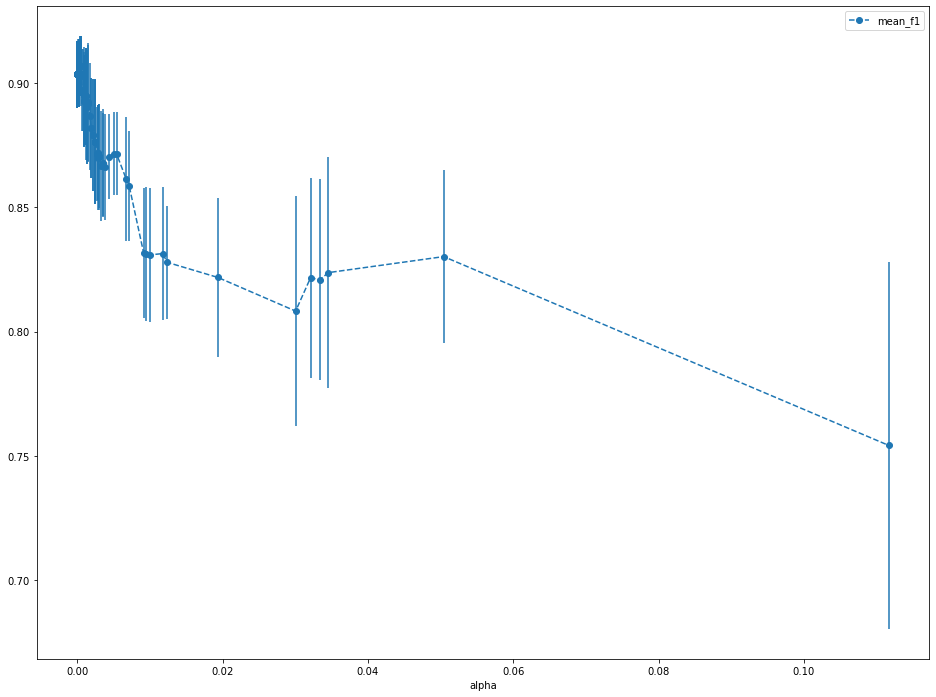

In [9]:
### PLOTTING THE CROSS VALIDATED F1 SCORES FOR TRAINING AGAINST CCP_ALPHA VALUES
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced', ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'f1_weighted')
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
alpha_results = pd.DataFrame(alpha_loop_values, columns = ['alpha', 'mean_f1', 'std_f1'])
fig, ax = plt.subplots(figsize = (16, 12))
alpha_results.plot(x = 'alpha',
                  y = 'mean_f1',
                  yerr = 'std_f1',
                  marker = 'o',
                  linestyle = '--',
                  ax = ax)
plt.show()

We see that the f1_weighted score reaches maximum in the range 0.00 < ccp_alpha < 0.02. We shall consider the ccp_alpha corresponding to the largest f1_weighted score as our ideal ccp_alpha value.

In [10]:
### GETTING THE IDEAL CCP_ALPHA VALUE
ideal_ccp_alpha = float(min(alpha_results[alpha_results['mean_f1'] == max(alpha_results['mean_f1'])]['alpha']))
ideal_ccp_alpha

0.00045537340619308385

With this value, we shall prune the baseline model to get a new tree model.

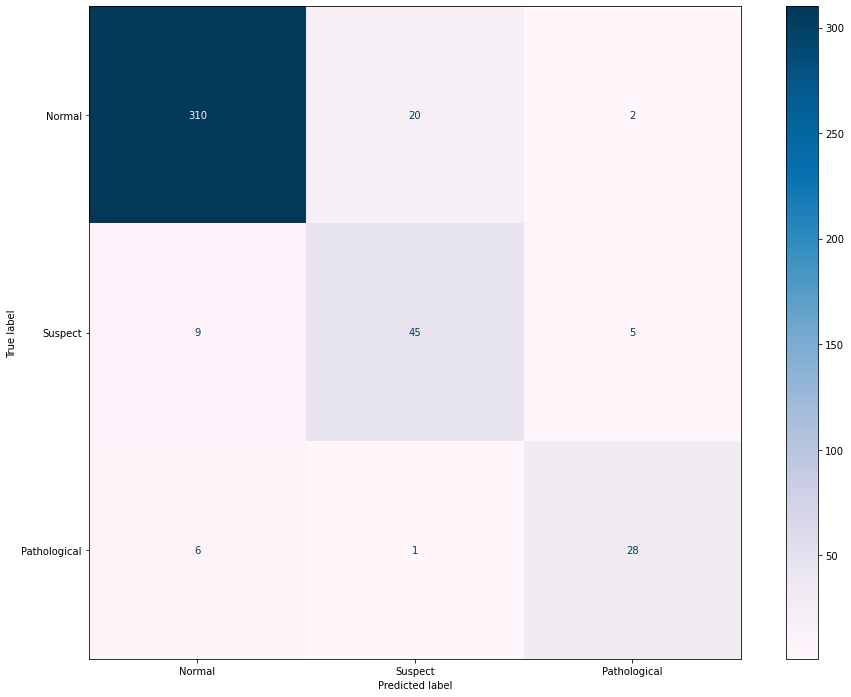

In [11]:
### CREATING A PRUNED TREE MODEL
clf_dt = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced', ccp_alpha = ideal_ccp_alpha)
clf_dt.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (16, 12))
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['Normal', 'Suspect', 'Pathological'], ax = ax, cmap = plt.cm.PuBu)

We dont see any difference with regards to the fetuses that had health issues. On the other hand, of the 59 suspected cases, 45 were correctly identified by the new model while 9 were mislabelled as normal. This is much better than our baseline model.

In [12]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['Normal', 'Suspect', 'Pathological']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt, average = 'weighted'))
print('F1 score: %f' % f1_score(y_test, y_pred_dt, average = 'weighted'))

              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       332
     Suspect       0.68      0.76      0.72        59
Pathological       0.80      0.80      0.80        35

    accuracy                           0.90       426
   macro avg       0.81      0.83      0.82       426
weighted avg       0.90      0.90      0.90       426

Accuracy: 0.899061
Recall score: 0.899061
F1 score: 0.900899


The recall score and accuracy have both gone up to about 89.9%; the F1 score has also increased to about 90.1%.

We can also plot the new tree model.

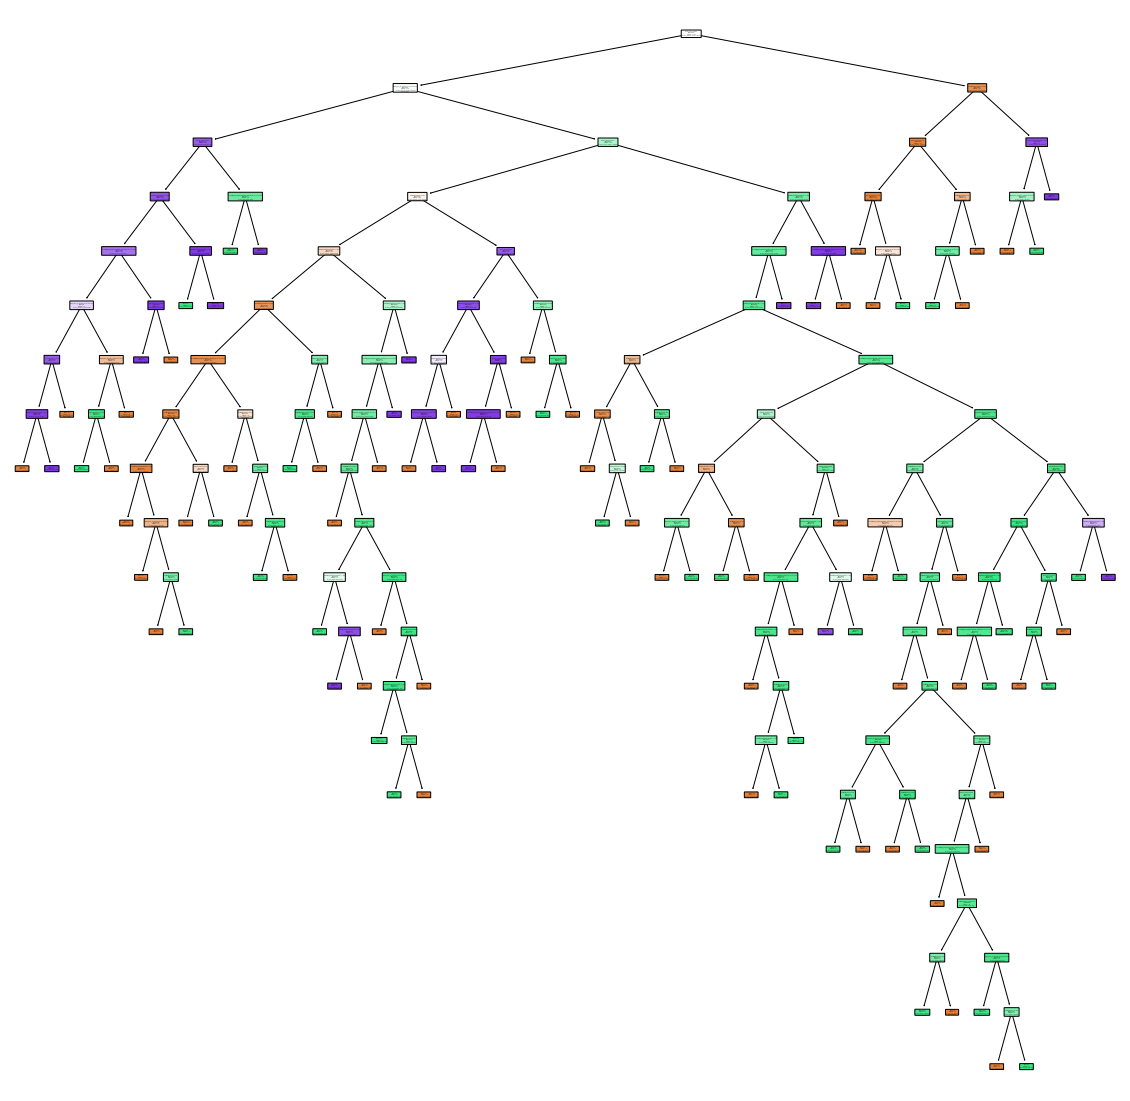

In [13]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (20, 20))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['Normal', 'Suspect', 'Pathological'], feature_names = X.columns);

Although this new tree seems less crowded than the previous one, it is still hard to interpret how it categorises fetus health. We can however restrict the depth of this tree to make it more interpretable. For this, we shall resort to hyperparameter tuning.

We shall use a grid search with 5 fold cross-validation across the possible values for the hyperparameters _'criterion'_ and _'max_depth'_. We will use f1_weighted as our scoring parameter.

The hyperparameter _'criterion'_ determines how the impurity in a split is measured while making a tree. The candidates are as follows:

1. gini: it is a measure of the frequency at which any element of the dataset will be mislabelled when it is randomly labeled.
2. entropy: it is a measure of the purity of a split

In [14]:
### TUNING HYPERPARAMETER VALUES USING GRID SEARCH
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2, 20)
}
clf = DecisionTreeClassifier(random_state = 123, class_weight = 'balanced', ccp_alpha = ideal_ccp_alpha)
grid_fit = GridSearchCV(estimator = clf,
                          param_grid = param_grid,
                          scoring = 'f1_weighted',
                          cv = 5,
                          verbose = 2,
                          n_jobs = -1)
grid_fit.fit(X_train, y_train)
print('Best F1 score: %f' % grid_fit.best_score_)
print('Best criterion: %s' % grid_fit.best_estimator_.get_params()['criterion'])
print('Best max_depth: %d' % grid_fit.best_estimator_.get_params()['max_depth'])                                     

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s


Best F1 score: 0.915509
Best criterion: entropy
Best max_depth: 19


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    5.8s finished


Now, with these tuned hyperparameter values, we shall create our final Decision Tree model.

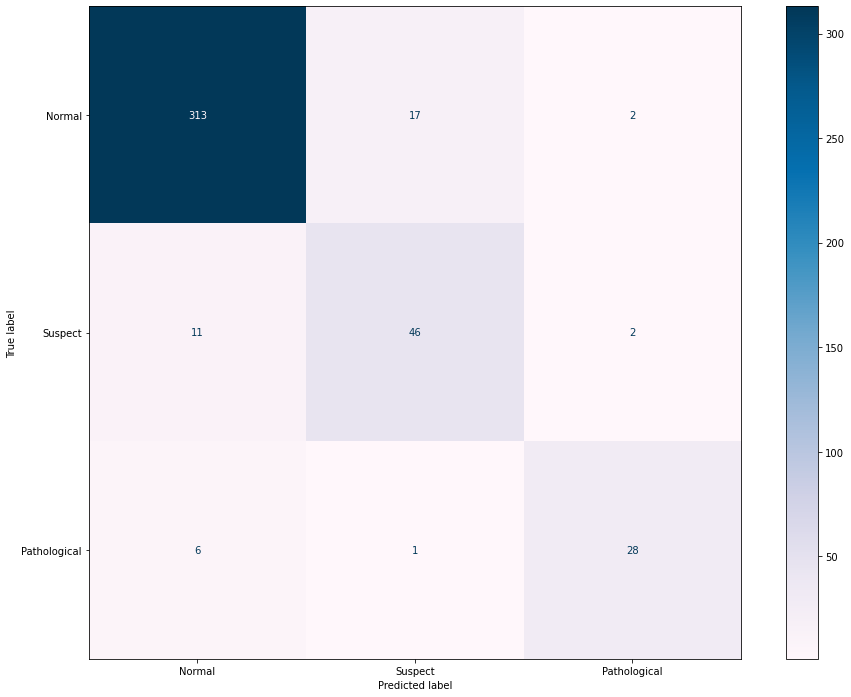

In [15]:
### CREATING THE FINAL MODEL
clf_dt = DecisionTreeClassifier(random_state = 123, 
                                class_weight = 'balanced', 
                                ccp_alpha = ideal_ccp_alpha,
                                criterion = 'entropy',
                                max_depth = 19)
clf_dt.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (16, 12))
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels = ['Normal', 'Suspect', 'Pathological'], ax = ax, cmap = plt.cm.PuBu)

Like the second model, we dont see any difference with regards to the fetuses that had health issues. On the other hand, of the 59 suspected cases, 46 were correctly identified by the new model while 11 were mislabelled as normal. So we have a better model in terms of predicting suspected cases. 

In [16]:
### CALCULATING ESSENTIAL METRICS
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['Normal', 'Suspect', 'Pathological']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_dt))
print('Recall score: %f' % recall_score(y_test, y_pred_dt, average = 'weighted'))
print('F1 score: %f' % f1_score(y_test, y_pred_dt, average = 'weighted'))

              precision    recall  f1-score   support

      Normal       0.95      0.94      0.95       332
     Suspect       0.72      0.78      0.75        59
Pathological       0.88      0.80      0.84        35

    accuracy                           0.91       426
   macro avg       0.85      0.84      0.84       426
weighted avg       0.91      0.91      0.91       426

Accuracy: 0.908451
Recall score: 0.908451
F1 score: 0.909224


The recall score and accuracy have both gone up to about 90.8%; the F1 score has also increased to about 90.9%.

We can also plot this final tree model.

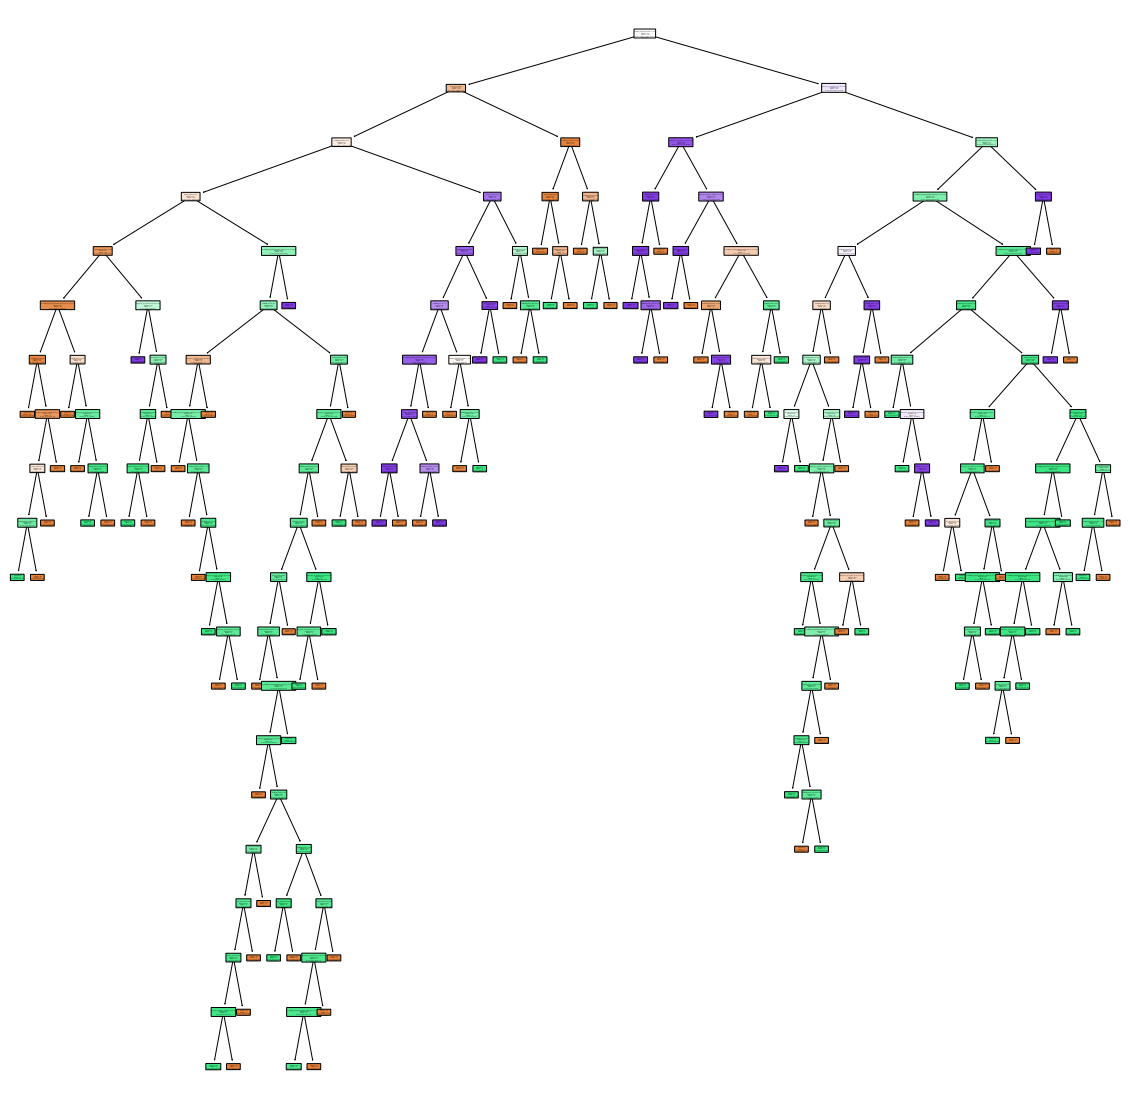

In [17]:
### PLOTTING THE TREE MODEL
plt.figure(figsize = (20, 20))
plot_tree(clf_dt, rounded = True, filled = True, class_names = ['Normal', 'Suspect', 'Pathological'], feature_names = X.columns);

The tree model is still not as interpretable as we want it to be even after restricting it's size. However, it does the best job at predicting suspected and unhealthy fetuses.